In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_MAX_ACTIVE_LEVELS"] = "1"


In [3]:
import pyreadr
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as sch

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from scipy.optimize import minimize
from scipy.stats import chi2
from tqdm import tqdm  # import tqdm for progress bar
import warnings

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, approx_fprime
from matplotlib.patches import Ellipse
import matplotlib.patches as patches
import matplotlib.transforms as transforms


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D


## Single-Cell RNA Sequencing Data (Zheng et al. 2017)

Single-cell RNA sequencing (scRNA-seq) data captures gene expression profiles at the resolution of individual cells, enabling researchers to explore cellular heterogeneity. A common analysis strategy involves clustering cells to infer putative cell types, followed by differential gene expression analysis between the resulting groups. However, conventional methods often overlook the uncertainty inherent in the clustering step (Luecken and Theis, 2019; Lähnemann et al., 2020; Deconinck et al., 2021) [1]. In our analysis, we utilize a publicly available scRNA-seq dataset from peripheral blood mononuclear cells (PBMCs), originally pre-classified prior to sequencing by Zheng et al. (2017), to illustrate how our proposed soft-clustering selective inference framework can provide valid and informative differential expression results while properly accounting for the fuzziness in cluster assignments.

### Data Pre-processing

For our analysis, we focus on a subset of peripheral blood mononuclear cells consisting of memory T cells, B cells, and monocytes. Following standard single-cell RNA-seq preprocessing procedures (Duò, Robinson, and Soneson, 2018), we filter out cells with a high proportion of mitochondrial gene expression, cells with an unusually low or high number of expressed genes, and those with low total UMI counts. To account for size differences, we normalize the data such that each cell has the same total count equal to the average across all cells. We then apply a log2 transformation with a pseudocount of 1. To reduce dimensionality while retaining informative features, we select the top 500 genes with the highest average expression prior to normalization. This preprocessing pipeline is applied to the combined set of memory T cells, B cells, and monocytes. We construct an imbalanced clustered dataset, consisting of 1,500 memory T cells, 1,000 B cells, and 500 monocytes, totaling 3,000 cells. The dataset allows us to assess the robustness of our method under imbalanced cluster structures.


### Reference
[1] Gao, Lucy L., Jacob Bien, and Daniela Witten. "Selective inference for hierarchical clustering." Journal of the American Statistical Association 119.545 (2024): 332-342.


In [5]:
result = pyreadr.read_r("data/processed_mix3_df.rds")
df = result[None]
X = df.drop(columns=["CellType"]).values
labels = df["CellType"].values

# Get indices for each cell type
tcell_id = np.where(df["CellType"] == "Memory T cell")[0]
bcell_id = np.where(df["CellType"] == "B cell")[0]
mono_id = np.where(df["CellType"] == "Monocyte")[0]

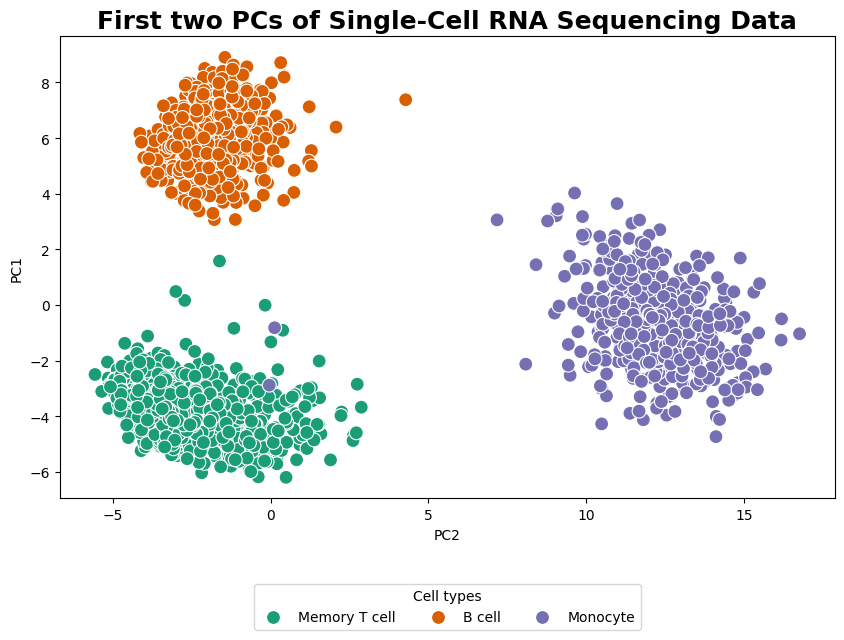

In [6]:
# Sample 500, 1000, 1500 cells from each type
ss_id2 = np.concatenate([
    np.random.choice(tcell_id, 1500, replace=False),
    np.random.choice(bcell_id, 1000, replace=False),
    np.random.choice(mono_id, 500, replace=False)
])
X2_sampled = X[ss_id2, :]  


# Ensure that X1 is a dense matrix (if it's sparse)
X2_dense = X2_sampled.toarray() if isinstance(X2_sampled, np.ndarray) is False else X2_sampled


# PCA: We reduce to 2 principal components
pca = PCA(n_components=2)
pca_data2 = pca.fit_transform(X2_dense)

# Create a DataFrame for the PCA results with PC1, PC2, and CellType (from processed_mix3)
pca_df2 = pd.DataFrame(pca_data2, columns=['PC1', 'PC2'])
pca_df2['CellType'] = labels[ss_id2]

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df2, x='PC1', y='PC2', hue='CellType', palette='Dark2', s=100)
plt.title('First two PCs of Single-Cell RNA Sequencing Data', fontsize = 18, weight = "bold")
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.legend(title='Cell types', loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
#plt.gca().set_aspect(6/6)  # Adjust the aspect ratio
plt.show()


# scale the data
scaler = StandardScaler()
pc_scaled2 = scaler.fit_transform(pca_df2[['PC1', 'PC2']])
df_scaled2 = pd.DataFrame(pc_scaled2, columns=pca_df2[['PC1', 'PC2']].columns)
df_combined2 = pd.concat([df_scaled2, pca_df2[['CellType']]], axis=1)


# Apply K-Means
kmeans2 = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans2.fit(df_scaled2)
# Get centroids
centroids2 = kmeans2.cluster_centers_
# Convert back to original scale
centroids_original = scaler.inverse_transform(centroids2)

In [19]:

# =============================================
# 1) TARGET DENSITY FOR c=4 CLUSTER FUZZY MODEL
# =============================================
def target_density_ccluster(x, sigma, centers, m, w, epsilon=1e-8):
    """
    Unnormalized density for a c-cluster fuzzy model in 2D:

        f(x) = exp( -1/(sigma^2) *
                    [ ( sum_{j=1 to c} [ (w_j * ||x - centers[j]||^2)^(-1/(m-1)) ] ) ]^(m-1)
                  ).

    x       : (N, 2) array of points
    centers : (4, 2) array of cluster centroids
    w       : (4,)  array of cluster weights in [0,1], sum(w)=1
    sigma   : scale parameter > 0
    m       : fuzzy exponent in (1, 3)
    """
    N = x.shape[0]
    c = centers.shape[0]

    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(x - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j ** 2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))

    sum_dist = np.sum(dist_power, axis=1) + epsilon
    denom = (sum_dist)**(m - 1.0) 

    exponent = -1.0 / (sigma**2 * denom + epsilon)
    return np.exp(exponent)


# =============================================
# 2) METROPOLIS–HASTINGS SAMPLER FOR c CLUSTERS
# =============================================
def metropolis_hastings_ccluster(
    sigma, centers, m, w,
    initial_point=None,
    iterations=10000,
    proposal_std=1.0,
    burn_in=0.1,
    seed=42
):
    """
    Draw samples from the c-cluster fuzzy density using Metropolis-Hastings.

    Returns:
      samples   : shape ((1-burn_in)*iterations, p)
      acc_rate  : acceptance fraction
    """
    np.random.seed(seed)
    if initial_point is None:
        initial_point = np.zeros(centers.shape[1])

    samples = np.zeros((iterations, centers.shape[1]))
    samples[0] = initial_point
    accepted = 0

    current_val = target_density_ccluster(
        samples[0].reshape(1, -1), sigma, centers, m, w
    )[0]

    for i in range(1, iterations):
        current = samples[i - 1]
        proposal = current + np.random.randn(centers.shape[1]) * proposal_std

        proposal_val = target_density_ccluster(
            proposal.reshape(1, -1), sigma, centers, m, w
        )[0]

        alpha = min(1.0, proposal_val / (current_val + 1e-30))
        if np.random.rand() < alpha:
            samples[i] = proposal
            current_val = proposal_val
            accepted += 1
        else:
            samples[i] = current

    acc_rate = accepted / (iterations - 1)
    burn_in_steps = int(iterations * burn_in)
    return samples[burn_in_steps:], acc_rate


# =============================================
# 3) MEMBERSHIP UPDATE (E-step) FOR c CLUSTERS
# =============================================
def update_membership_c(data, centers, w, m, epsilon=1e-8):
    """
    E-step: membership U (N,c) for c clusters.

    U[i,j] = [ (w_j * ||x_i - centers[j]||^2)^(-1/(m-1)) ] / sum_k [ (w_k * ||x_i-centers[k]||^2)^(-1/(m-1)) ]
    """
    N = data.shape[0]
    c = centers.shape[0]

    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(data - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))

    denom = np.sum(dist_power, axis=1, keepdims=True) + epsilon
    U = dist_power / denom
    return U


# =============================================
# 4) CENTROID UPDATE (M-step, part A) FOR c CLUSTERS
# =============================================
def update_centroids_c(data, U, w, m, epsilon=1e-8):
    """
    Update c centroids in closed form:
      centers[j] = ( sum_i [ (U[i,j]^m) * x_i ] ) / sum_i [ (U[i,j]^m) ]
    """
    c = U.shape[1]
    N, dim = data.shape
    new_centers = np.zeros((c, dim))

    for j in range(c):
        u_pow = (U[:, j]**m) #* w[j]
        numerator = np.sum(u_pow[:, None] * data, axis=0)
        denominator = np.sum(u_pow) + epsilon
        new_centers[j] = numerator / denominator

    return new_centers


# =============================================
# 5) PARTIAL NLL (U fixed) for 4 Clusters
# =============================================
def partial_negative_log_likelihood_c(
    params, data, U, proposal_samples, proposal_weights, m, epsilon=1e-8
):
    """
    NLL with membership U fixed for c clusters.

    params: Flattened parameter vector: [sigma, center_1_coords..., center_c_coords..., w_1, ..., w_c]
        where each center has p coordinates.

    - Approx Z via importance sampling.
    - Then NLL = N*ln(Z) + sum_i [1/( sigma^2 * [4* sum_j(...) ]^(m-1)) ]
    """
    # Unpack
    params = np.array(params, dtype=float)
    
    sigma = params[0]
    remaining = len(params) - 1
    p = data.shape[1]
    c = remaining // (p+1)

    # Next 4*2=8 entries for centers
    center_vals = params[1 : 1 + p*c]
    centers = center_vals.reshape((c, p))

    # Next 4 entries for weights
    w = params[1 + p*c : 1 + (p+1)*c]

    N = data.shape[0]

    # 1) "Energy" term
    dist_power = np.zeros((N, c))
    for j in range(c):
        dist_j = np.linalg.norm(data - centers[j], axis=1) + epsilon
        dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))

    sum_dist = np.sum(dist_power, axis=1) + epsilon
    denom_data = (sum_dist)**(m - 1.0) + epsilon  # c=3
    energy = np.sum(1.0 / (sigma**2 * denom_data))

    # 2) Importance sampling for Z
    f_vals = target_density_ccluster(proposal_samples, sigma, centers, m, w, epsilon=epsilon)
    ratio = f_vals / (proposal_weights + epsilon)
    Z_est = np.mean(ratio) + epsilon

    NLL = N * np.log(Z_est) + energy
    return NLL


# =============================================
# 6) EM-LIKE FUZZY CLUSTERING FOR 4 Clusters
# =============================================
def em_like_fuzzy_clustering_c(
    data,
    proposal_samples,
    proposal_weights,
    m,
    c, 
    initial_sigma=1.0,
    initial_centers=None,
    initial_w=None,
    max_iter=30,
    tol=1e-5,
    random_state=321
):
    """
    c-Cluster version of the EM-like approach:
      - E-step: membership U
      - M-step(A): update centers in closed form
      - M-step(B): optimize sigma, w (holding U fixed)
      - repeat until convergence
    """
    rng = np.random.RandomState(random_state)
    N, p = data.shape
    #c = initial_centers.shape[0]

    # --- Initialize sigma
    sigma = initial_sigma

    # --- Initialize centers
    if initial_centers is None:
        idx = rng.choice(N, c, replace=False)
        centers = data[idx].copy()  
    else:
        centers = np.asarray(initial_centers).reshape(c, p)

    # --- Initialize weights
    if initial_w is None:
        w = np.ones(c) / c
    else:
        w = np.asarray(initial_w, dtype=float)
        w = w / (w.sum() + 1e-12)

    old_nll = np.inf

    for iteration in range(max_iter):
        # E-step
        U = update_membership_c(data, centers, w, m)

        # M-step (A): update centers
        centers = update_centroids_c(data, U, w, m)

        # M-step (B): refine sigma, w, keeping U fixed
        # Flatten: [ sigma, (4x2 centers), (4 weights) ] => total 13
        x0 = [sigma] + list(centers.flatten()) + list(w)
        # Bounds
        # sigma > 0 => (1e-5, 100)
        # centers => no bound
        # w_j in [0,1]
        bnds = [(1e-5, 100.)]  # sigma
        for _ in range(c*2):
            bnds.append((None, None))  # center coords
        for _ in range(c):
            bnds.append((0., 1.))

        def objective(params):
            return partial_negative_log_likelihood_c(
                params, data, U, proposal_samples, proposal_weights, m
            )

        res = minimize(objective, x0, method="L-BFGS-B", bounds=bnds)
        if res.success:
            p_opt = np.array(res.x, dtype=float)
            sigma_opt = p_opt[0]
            cvals_opt = p_opt[1 : 1 + p*c]
            centers_opt = cvals_opt.reshape((c, p))
            w_opt = p_opt[1 + p*c : 1 + (p+1)*c]
            # Force sum(w)=1
            w_opt = w_opt / (w_opt.sum() + 1e-12)

            sigma, centers, w = sigma_opt, centers_opt, w_opt

        # Check for convergence
        new_nll = partial_negative_log_likelihood_c(
            [sigma] + list(centers.flatten()) + list(w),
            data, U, proposal_samples, proposal_weights, m
        )
        improvement = abs(old_nll - new_nll)
        #print(f"Iter {iteration+1}/{max_iter}  NLL={new_nll:.6f}  Δ={improvement:.2e}")
        if improvement < tol:
            break
        old_nll = new_nll

    return {
        "sigma": sigma,
        "centers": centers,
        "w": w,
        "m": m,
        "U": U,
        "NLL": old_nll
    }


# =============================================
# 7) GMM PROPOSAL FOR IMPORTANCE SAMPLING
# =============================================
def generate_proposal_samples_gmm(data, num_samples=5000, n_components=3, random_state=42):
    """
    Fit a GMM to 'data' and draw samples for importance sampling.
    By default, n_components=4 (can be changed).
    Returns:
      samples_IS : (num_samples, p)
      proposal_pdf : (num_samples,) = q(x)
    """
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=random_state)
    gmm.fit(data)
    samples_IS, _ = gmm.sample(num_samples)
    proposal_pdf = np.exp(gmm.score_samples(samples_IS))
    return samples_IS, proposal_pdf, gmm



# ----------------------------------------------------
# 8) XIE–BENI INDEX
# ----------------------------------------------------
def xie_beni_index(data, U, centers, m, c, w, epsilon=1e-14):
    """
    Compute the Xie–Beni index for fuzzy clustering.
      XB = [ sum_{i=1}^N sum_{j=1}^c (U[i,j]^m) * ||x_i - center_j||^2 ]
            / [ N * min_{k != l} (||center_k - center_l||^2) ]

    Smaller XB => better clustering.
    """
    N, d = data.shape
    c = centers.shape[0]
    U_m = U**m

    # (1) Numerator: sum of (U[i,j]^m * ||x_i - center_j||^2)
    dist_sq = np.zeros((N, c))
    for j in range(c):
        diff = data - centers[j]
        dist_sq[:, j] = np.sum(diff**2, axis=1)  # squared distance

    numerator = np.sum(c * w * U_m * dist_sq)

    # (2) Denominator: N * min pairwise distance among cluster centers
    min_sq_dist = np.inf
    for k in range(c):
        for l in range(k+1, c):
            center_diff = centers[k] - centers[l]
            dist_sq_kl = np.sum(center_diff**2)
            if dist_sq_kl < min_sq_dist:
                min_sq_dist = dist_sq_kl

    if min_sq_dist < epsilon:
        # If two centers are extremely close, XB can blow up
        return np.inf

    denominator = N * min_sq_dist
    xb_val = numerator / denominator
    return xb_val


# =============================================
# 8) PARAMETRIC BOOTSTRAP FOR c-CLUSTER MODEL
# =============================================
def sample_from_fit_ccluster(theta, N, iterations=30000, burn_in=0.2, proposal_std=1.0, seed=123):
    """
    Generate N synthetic samples from the fitted 4-cluster fuzzy model
    using Metropolis-Hastings.

    theta: dict with keys ["sigma","centers","m","w"]
    """
    sigma_syn = theta["sigma"]
    centers_syn = theta["centers"]
    w_syn = theta["w"]
    m_syn = theta["m"]
    # Just pick the first center as an initial point, or (0,0).
    initial_point = centers_syn[0]

    samples_mh, acc_rate = metropolis_hastings_ccluster(
        sigma_syn, centers_syn, m_syn, w_syn,
        initial_point=initial_point,
        iterations=iterations,
        proposal_std=proposal_std,
        burn_in=burn_in,
        seed=seed
    )

    if samples_mh.shape[0] > N:
        samples_mh = samples_mh[:N]
    return samples_mh


def parametric_bootstrap_ccluster(
    fitted_result,
    N_original,
    B=50,
    proposal_samples=None,
    proposal_weights=None,
    max_iter=30,
    random_state=999
):
    """
    Parametric bootstrap for 3-cluster fuzzy model.

    1) Generate data from fitted distribution (theta_hat).
    2) Refit the 3-cluster model.
    3) Collect distribution of re-fitted parameters.
    """
    rng = np.random.RandomState(random_state)

    # Unpack final fitted params
    sigma_hat = fitted_result["sigma"]
    centers_hat = fitted_result["centers"]  # shape (3,2)
    w_hat = fitted_result["w"]              # shape (3,)
    m_hat = fitted_result["m"]

    c_val = centers_hat.shape[0]
    p = centers_hat.shape[1]

    # param vector length => 1 + 2*3 + 3 = 10
    bootstrap_estimates = np.zeros((B, 1+ (p+1)*c_val))

    def flatten_params(sigma_val, centers_val, w_val):
        return np.concatenate(([sigma_val], centers_val.flatten(), w_val))

    orig_flat = flatten_params(sigma_hat, centers_hat, w_hat)
    print("\nOriginal final fit (flattened):\n", orig_flat)

    for b_i in range(B):
        # 1) Generate synthetic dataset
        seed_b = rng.randint(0, 999999)
        synthetic_data = sample_from_fit_ccluster(
            fitted_result,
            N=N_original,
            iterations=30000,
            burn_in=0.2,
            proposal_std=1.0,
            seed=seed_b
        )

        # 2) Refit
        refit = em_like_fuzzy_clustering_c(
            data=synthetic_data,
            proposal_samples=proposal_samples,
            proposal_weights=proposal_weights,
            m=m_hat,
            c=c_val,
            initial_sigma=sigma_hat,
            initial_centers=centers_hat,
            initial_w=w_hat,
            max_iter=max_iter,
            tol=1e-5,
            random_state=seed_b
        )

        sigma_b = refit["sigma"]
        centers_b = refit["centers"]
        w_b = refit["w"]

        bootstrap_estimates[b_i, :] = flatten_params(sigma_b, centers_b, w_b)

        print(f"[Bootstrap {b_i+1}/{B}]  sigma={sigma_b:.3f}, w={w_b}, centers=\n{centers_b}")

    return bootstrap_estimates


# -----------------------------
# 9) Helper for 2D Ellipses
# -----------------------------
def plot_ellipse_2d(ax, mean2d, cov2d, chi2_val=5.991, **kwargs):
    """
    Plots a 2D ellipse corresponding to the contour:
        (x - mean)^T * cov^-1 * (x - mean) = chi2_val
    For a 95% region in 2D, chi2_val ~ 5.991 (df=2).

    mean2d : (2,) array
    cov2d  : (2,2) array
    """
    eigvals, eigvecs = np.linalg.eigh(cov2d)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width  = 2.0 * np.sqrt(eigvals[0] * chi2_val)
    height = 2.0 * np.sqrt(eigvals[1] * chi2_val)
    ell = patches.Ellipse(xy=mean2d, width=width, height=height, angle=angle, **kwargs)
    ax.add_patch(ell)



In [12]:
# (B) Generate a GMM proposal for importance sampling
samples_IS, proposal_pdf, _ = generate_proposal_samples_gmm(
    pc_scaled2, num_samples=pc_scaled2.shape[0], random_state=42
)

# (C) Estimate # of clusters by scanning over c_candidates
c_candidates = [3]
best_c = None
best_xb_value = np.inf
best_result = None

#m_val = 2.0
m_candidates = np.geomspace(1.1, 6, num=3) 
xb_matrix = np.zeros((len(m_candidates), len(c_candidates)))

print("\n=== Estimating # of Clusters via Xie–Beni Index ===")
for i, m_val in enumerate(m_candidates):
    for j, c_val in enumerate(c_candidates):
        print(f"\n--- Trying c = {c_val}, m = {m_val} ---")

        # Run EM-like fuzzy clustering
        result_c = em_like_fuzzy_clustering_c(
            data=pc_scaled2,
            proposal_samples=samples_IS,
            proposal_weights=proposal_pdf,
            m=m_val,
            c=c_val,
            initial_sigma=1.0,
            max_iter=20  # adjust as needed
        )

        # Compute the Xie–Beni index
        xb_val = xie_beni_index(
            data=pc_scaled2,
            U=result_c["U"],
            centers=result_c["centers"],
            m=m_val, 
            c=c_val, 
            w = result_c["w"]
        )
        xb_matrix[i, j] = xb_val
        print(f"Xie–Beni index for c={c_val} => {xb_val:.4f}")

        # Skip if XB index is 0 or any other unwanted value
        if xb_val < 0.0008:
            continue

        # Track the best (lowest) XB
        if xb_val < best_xb_value:
            best_xb_value = xb_val
            best_c = c_val
            best_result = result_c
            best_m = m_val

print("\n===== Final Results =====")
print(f"Best fuzzy index m by XB = {best_m}")
print(f"Best number of clusters by XB = {best_c}")
print(f"XB value = {best_xb_value:.4f}")
print(f"Estimated sigma = {best_result['sigma']:.3f}")
print(f"Estimated centers = \n{best_result['centers']}")
print(f"Estimated weights = {best_result['w']}")



=== Estimating # of Clusters via Xie–Beni Index ===

--- Trying c = 3, m = 1.1 ---


/var/folders/pk/rhd1g8td4rl77hm70nrdkd6h0000gn/T/ipykernel_18971/2089496545.py:163: RuntimeWarning: divide by zero encountered in power
  dist_power[:, j] = (w[j] * dist_j**2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))
/var/folders/pk/rhd1g8td4rl77hm70nrdkd6h0000gn/T/ipykernel_18971/2089496545.py:24: RuntimeWarning: divide by zero encountered in power
  dist_power[:, j] = (w[j] * dist_j ** 2) ** (-1.0 / (m - 1.0)) #w[j] * dist_j**(-2.0 / (m - 1.0))


Xie–Beni index for c=3 => 2.0693

--- Trying c = 3, m = 2.5690465157330262 ---
Xie–Beni index for c=3 => 0.0128

--- Trying c = 3, m = 6.0 ---
Xie–Beni index for c=3 => 0.0006

===== Final Results =====
Best fuzzy index m by XB = 2.5690465157330262
Best number of clusters by XB = 3
XB value = 0.0128
Estimated sigma = 0.133
Estimated centers = 
[[ 2.22116295 -0.16341051]
 [-0.32166828  1.36035102]
 [-0.53234905 -0.86969405]]
Estimated weights = [0.341592   0.37431588 0.28409212]


Built GMM proposal for importance sampling.

===== Final Fit =====
 sigma = 0.14001208336112506
 centers =
 [[ 2.21050941 -0.20107565]
 [-0.55075638 -0.84034593]
 [-0.28995914  1.35993354]]
 w = [0.34213626 0.27844915 0.37941459]
 NLL = 2434.703715516044

Original final fit (flattened):
 [ 0.14001208  2.21050941 -0.20107565 -0.55075638 -0.84034593 -0.28995914
  1.35993354  0.34213626  0.27844915  0.37941459]
[Bootstrap 1/100]  sigma=0.137, w=[0.31663713 0.40982296 0.27353991], centers=
[[ 2.1982047  -0.1326804 ]
 [-0.57402275 -0.7575906 ]
 [-0.28613308  1.3880937 ]]
[Bootstrap 2/100]  sigma=0.143, w=[0.28736543 0.26576032 0.44687425], centers=
[[ 2.22413583 -0.20927219]
 [-0.58035586 -0.83784346]
 [-0.1992983   1.4308382 ]]
[Bootstrap 3/100]  sigma=0.130, w=[0.35360858 0.2302073  0.41618413], centers=
[[ 2.1896957  -0.21413977]
 [-0.53733597 -0.84485366]
 [-0.31400519  1.33421589]]
[Bootstrap 4/100]  sigma=0.138, w=[0.26739822 0.32377886 0.40882292], centers=
[[ 2.20514986 -0.17969293]

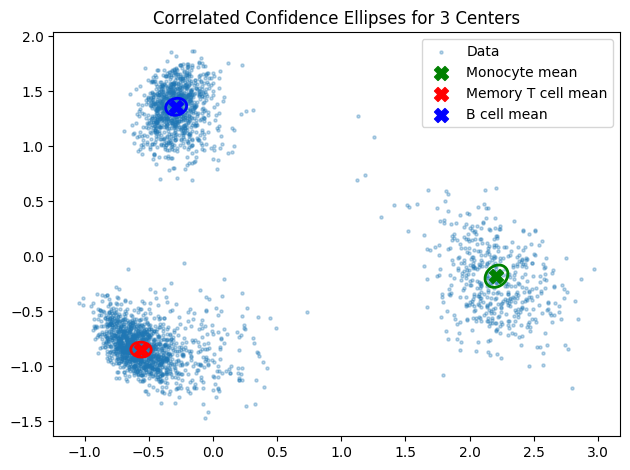

In [49]:

# =============================================
# 10) DEMO / MAIN
# =============================================
if __name__ == "__main__":
    data = pc_scaled2  # Singl Cell Data 1

    # -----------------------------------------
    # B) Build a GMM proposal for partial NLL
    # -----------------------------------------
    samples_IS, proposal_pdf, gmm = generate_proposal_samples_gmm(
        data, num_samples=5000, n_components=3, random_state=42
    )
    print("Built GMM proposal for importance sampling.")

    # -----------------------------------------
    # C) Fit the EM-like fuzzy clustering for c=3
    # -----------------------------------------
    result_fit = em_like_fuzzy_clustering_c(
        data=data,
        proposal_samples=samples_IS,
        proposal_weights=proposal_pdf,
        m=2.457,          # fix m=2 here
        c = 3,
        initial_sigma=1.0,
        max_iter=20,
        random_state=2023
    )

    print("\n===== Final Fit =====")
    print(" sigma =", result_fit["sigma"])
    print(" centers =\n", result_fit["centers"])
    print(" w =", result_fit["w"])
    print(" NLL =", result_fit["NLL"])

    # -----------------------------------------
    # D) Parametric Bootstrap for c=4
    # -----------------------------------------
    B = 100  # demo only; ideally 50 or 100
    boot_estimates = parametric_bootstrap_ccluster(
        fitted_result=result_fit,
        N_original=data.shape[0],
        B=B,
        proposal_samples=samples_IS,
        proposal_weights=proposal_pdf,
        max_iter=20,
        random_state=999
    )

    # E) Summarize the bootstrap
    print("\n=== Bootstrap Summaries ===")
    param_means = np.mean(boot_estimates, axis=0)
    param_stds  = np.std(boot_estimates, axis=0)

    # The order is [sigma, c1_x, c1_y, c2_x, c2_y, c3_x, c3_y, c4_x, c4_y, w1, w2, w3, w4]
    names = ["sigma",
             "c1_x","c1_y","c2_x","c2_y","c3_x","c3_y",
             "w1","w2","w3"]
    for i, nm in enumerate(names):
        print(f"{nm}: mean={param_means[i]:.3f}, std={param_stds[i]:.3f}")

    # 1D normal approx intervals
    z = 1.96
    ci_lo = param_means - z * param_stds
    ci_hi = param_means + z * param_stds
    print("\n95% CIs (normal approx):")
    for i, nm in enumerate(names):
        print(f"{nm} => ({ci_lo[i]:.3f}, {ci_hi[i]:.3f})")

    # -----------------------------------------
    # (F) Plot correlated confidence regions
    # We'll just show the 4 centers as separate 2D ellipses
    # plus we can do a 4D plot for w in 2D pairs if we want.
    # -----------------------------------------
    cov_full = np.cov(boot_estimates.T)  # shape (13,13)

    # We'll do submatrices for each centroid:
    # c1 => indices [1,2], c2 => [3,4], c3 => [5,6]
    # Then the weights => [7,8,9], but that is 3D
    mean_full = param_means
    center_idxs = [(1,3),(3,5),(5,7)]  # (start,end) slices
    fig, ax = plt.subplots()
    ax.scatter(data[:,0], data[:,1], s=5, alpha=0.3, label="Data")

    cluster_colors = ['green', 'red', 'blue']
    centroid_names = ['Monocyte', 'Memory T cell', 'B cell']
    for j in range(3):
        i_start, i_end = center_idxs[j]
        cov_j = cov_full[i_start:i_end, i_start:i_end]  # 2x2
        mean_j = mean_full[i_start:i_end]
        color_j = cluster_colors[j]# f"C{j}"  # simple color from matplotlib
        ax.scatter(mean_j[0], mean_j[1], c=color_j, marker='X', s=100, label=f"{centroid_names[j]} mean")

        # 95% ellipse
        plot_ellipse_2d(ax, mean_j, cov_j, chi2_val=5.991, fill=False, edgecolor=color_j, linewidth=2)

    ax.legend()
    ax.set_title("Correlated Confidence Ellipses for 3 Centers")
    plt.tight_layout()
    plt.show()




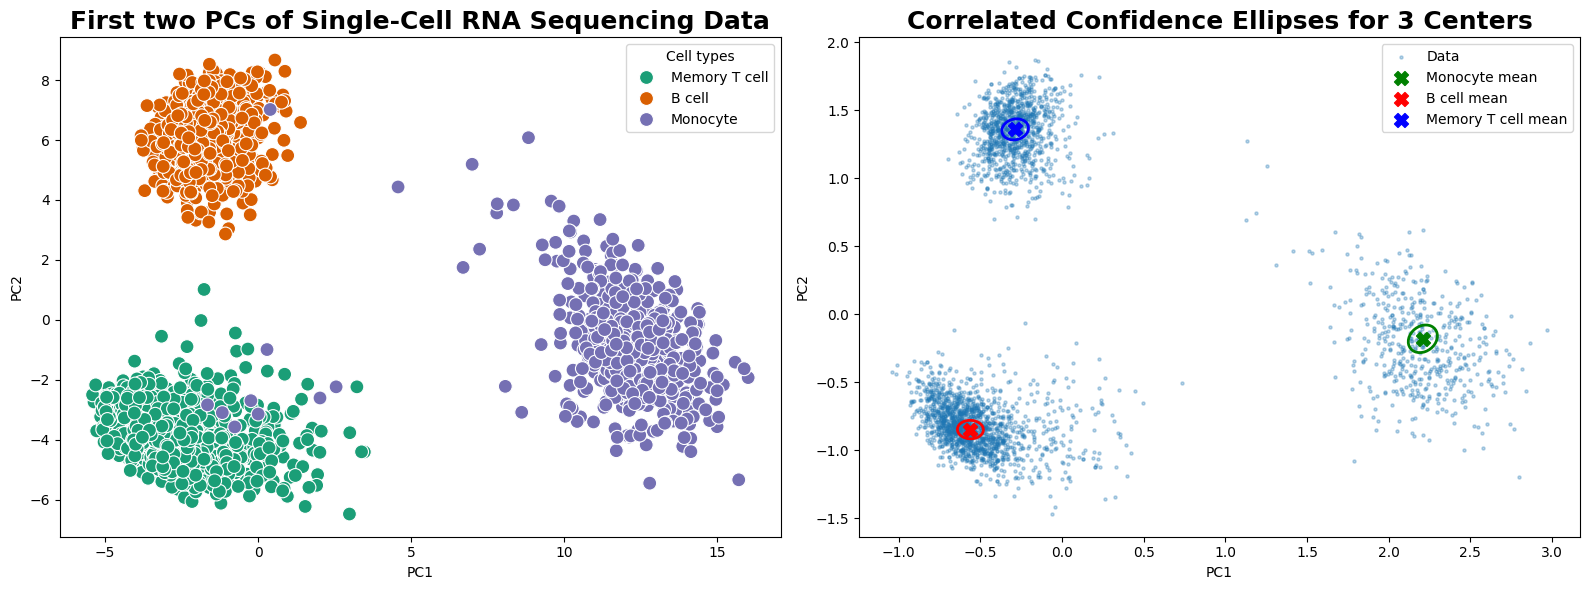

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# -------------------------------
# Left: PCA scatter
# -------------------------------
sns.scatterplot(
    data=pca_df2, x='PC1', y='PC2', hue='CellType',
    palette='Dark2', s=100, ax=ax1
)
ax1.set_title('First two PCs of Single-Cell RNA Sequencing Data', fontsize = 18, weight = "bold")
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.legend(title='Cell types', loc='upper right')

# -------------------------------
# Right: Confidence ellipses
# -------------------------------
ax2.scatter(data[:, 0], data[:, 1], s=5, alpha=0.3, label="Data")

cluster_colors = ['green', 'red', 'blue']
centroid_names = ['Monocyte', 'B cell', 'Memory T cell']
center_idxs = [(1, 3), (3, 5), (5, 7)]  # slices for centers
mean_full = param_means
cov_full = np.cov(boot_estimates.T)

for j in range(3):
    i_start, i_end = center_idxs[j]
    mean_j = mean_full[i_start:i_end]
    cov_j = cov_full[i_start:i_end, i_start:i_end]
    color_j = cluster_colors[j]

    ax2.scatter(mean_j[0], mean_j[1], c=color_j, marker='X', s=100, label=f"{centroid_names[j]} mean")
    plot_ellipse_2d(ax2, mean_j, cov_j, chi2_val=5.991, fill=False, edgecolor=color_j, linewidth=2)

ax2.set_title("Correlated Confidence Ellipses for 3 Centers", fontsize = 18, weight = "bold")
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.legend()

plt.tight_layout()
plt.show()


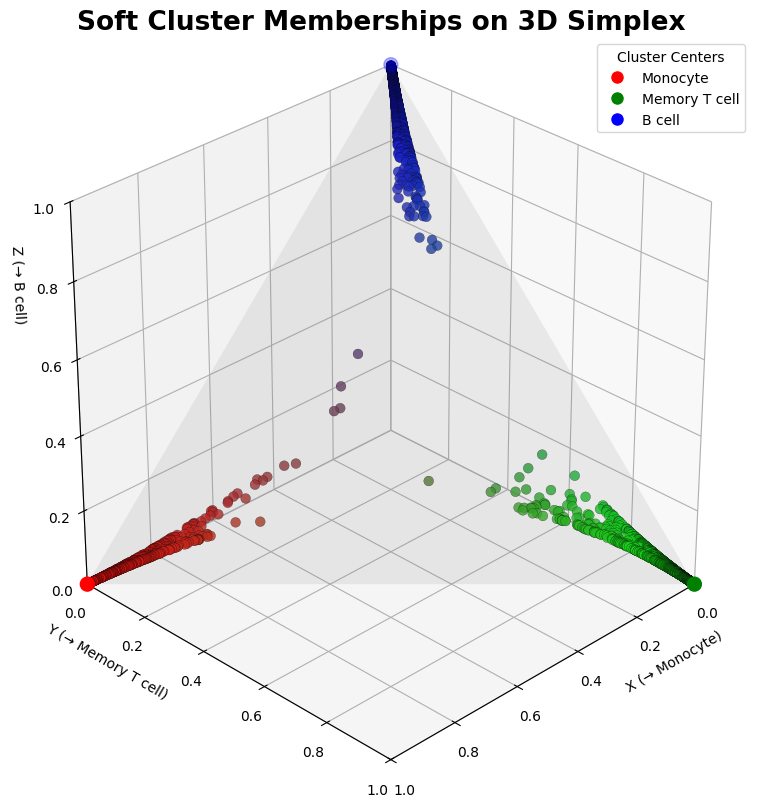

In [65]:

U = result_fit["U"]
# Step 5: Add memberships to DataFrame
for i in range(3):
    df_scaled2[f"Cluster{i+1}"] = U[:, i]

# Optional: Add true cell types for coloring later
df_scaled2['CellType'] = pca_df2['CellType'].values

# Make sure your U matrix is shape (n_samples, 3)
# If shape is (3, n_samples), transpose it
if U.shape[0] == 3:
    U = U.T

# Normalize U (in case fuzzy c-means didn't produce perfectly normalized memberships)
U_normalized = U / U.sum(axis=1, keepdims=True)

# Define corners of the triangle in 3D barycentric space
C1 = np.array([1, 0, 0])
C2 = np.array([0, 1, 0])
C3 = np.array([0, 0, 1])
corners = np.stack([C1, C2, C3])

# Project each membership vector onto 3D space using barycentric coordinates
points = U_normalized @ corners

# Color points by soft membership (RGB = Cluster 3, Cluster 2, Cluster 1)
colors = U_normalized[:, [0, 1, 2]]

# Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw the triangle simplex
ax.plot_trisurf(corners[:, 0], corners[:, 1], corners[:, 2],
                triangles=[[0, 1, 2]], color='lightgray', alpha=0.1)

# Plot triangle corners (cluster centers)
ax.scatter(corners[:, 0], corners[:, 1], corners[:, 2],
           c=['red', 'green', 'blue'], s=100)

# Plot data points colored by soft membership
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c=colors, s=50, alpha=0.8, edgecolor='k', linewidth=0.2)

# Optional: highlight the mean membership
# mean_point = points.mean(axis=0)
# ax.scatter(*mean_point, c='orange', s=120, marker='X', label='Mean Membership')

# Axis and title
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_box_aspect([1, 1, 1])
ax.view_init(elev=30, azim=45)
ax.set_xlabel('                                                    X (→ Monocyte)')
ax.set_ylabel('Y (→ Memory T cell)                                                    ')
ax.set_zlabel('Z (→ B cell)                                                    ')
ax.set_title('Soft Cluster Memberships on 3D Simplex', fontsize = 19, weight = 'bold')
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Monocyte',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Memory T cell',
           markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='B cell',
           markerfacecolor='blue', markersize=10)
]
ax.legend(handles=legend_elements, loc='upper right', title='Cluster Centers')


plt.tight_layout()
plt.show()


# WFCM vs GMM

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import numpy as np
import matplotlib.pyplot as plt

# === Inputs ===
data = pc_scaled2  # your 2D cell data
U_wfcm = result_fit["U"]
centers_wfcm = result_fit["centers"]

# -------------------------------
# 1. Fit GMM with same k as WFCM
# -------------------------------
c_candidates = [U_wfcm.shape[1]]
best_gmm, best_bic, best_c_gmm = None, np.inf, None

for c_val in c_candidates:
    print(f"\n--- Trying GMM with c = {c_val} ---")
    gmm = GaussianMixture(
        n_components=c_val,
        covariance_type="full",
        random_state=12,
        n_init=5,
        max_iter=300
    )
    gmm.fit(data)
    bic = gmm.bic(data)
    print(f"BIC for c={c_val}: {bic:.2f}")
    if bic < best_bic:
        best_bic = bic
        best_c_gmm = c_val
        best_gmm = gmm

print("\n===== GMM Final Results =====")
print(f"Best number of clusters by BIC = {best_c_gmm}")
print(f"Best BIC value = {best_bic:.2f}")
print(f"Means:\n{best_gmm.means_}")
print(f"Weights: {best_gmm.weights_}")

# GMM soft assignments
U_gmm = best_gmm.predict_proba(data)
centers_gmm = best_gmm.means_

# -------------------------------
# 2. Align GMM clusters to WFCM
# -------------------------------
cost_matrix = -U_wfcm.T @ U_gmm
row_ind, col_ind = linear_sum_assignment(cost_matrix)
U_gmm_aligned = U_gmm[:, col_ind]
centers_gmm_aligned = centers_gmm[col_ind, :]

# -------------------------------
# 3. Compare: ARI and Xie–Beni
# -------------------------------
def xie_beni_index(X, U, centers, m=2):
    n, k = U.shape
    dist_sq = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2) ** 2
    num = np.sum((U ** m) * dist_sq)
    denom = n * np.min([
        np.linalg.norm(centers[i] - centers[j]) ** 2
        for i in range(k) for j in range(k) if i != j
    ])
    return num / denom


ari = adjusted_rand_score(np.argmax(U_wfcm, axis=1), np.argmax(U_gmm_aligned, axis=1))
xb_wfcm = xie_beni_index(data, U_wfcm, centers_wfcm)
xb_gmm = xie_beni_index(data, U_gmm_aligned, centers_gmm_aligned)

print(f"\n--- Model Comparison ---")
print(f"BIC (GMM): {best_bic:.2f}")
print(f"Xie–Beni (WFCM): {xb_wfcm:.4f}")
print(f"Xie–Beni (GMM): {xb_gmm:.4f}")
print(f"ARI (WFCM vs GMM): {ari:.3f}")





--- Trying GMM with c = 3 ---
BIC for c=3: 3817.31

===== GMM Final Results =====
Best number of clusters by BIC = 3
Best BIC value = 3817.31
Means:
[[-0.50372762 -0.84068415]
 [ 2.18299531 -0.1471269 ]
 [-0.3332474   1.3349172 ]]
Weights: [0.50027732 0.16633323 0.33338945]


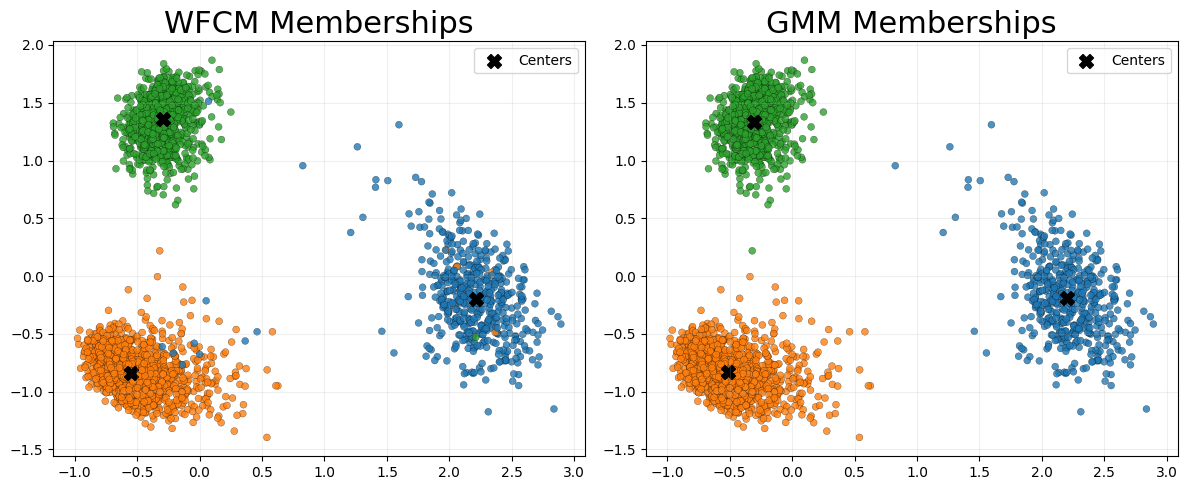

In [71]:

from matplotlib.colors import ListedColormap

# Define custom discrete colors for 3 clusters
cluster_colors = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])  # blue, orange, green

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, U, centers, title in zip(
    axes,
    [U_wfcm, U_gmm_aligned],
    [centers_wfcm, centers_gmm_aligned],
    ["WFCM Memberships", "GMM Memberships"]
):
    cluster_ids = np.argmax(U, axis=1)
    scatter = ax.scatter(
        data[:, 0], data[:, 1],
        c=cluster_ids,
        cmap=cluster_colors,
        s=25, alpha=0.8, edgecolor='k', linewidth=0.2
    )
    ax.scatter(
        centers[:, 0], centers[:, 1],
        c='black', s=100, marker='X', label='Centers'
    )
    ax.set_title(title, fontsize=22)
    ax.grid(alpha=0.2)
    ax.legend()

plt.tight_layout()
plt.show()

In [77]:
# (B) Generate a GMM proposal for importance sampling
samples_IS, proposal_pdf, _ = generate_proposal_samples_gmm(
    pc_scaled2, num_samples=pc_scaled2.shape[0], random_state=42
)

# (C) Estimate # of clusters by scanning over c_candidates
c_candidates = [2,3,4,5,6,7]
best_c = None
best_xb_value = np.inf
best_result = None

#m_val = 2.0
m_candidates = np.geomspace(1.1, 6, num=10) 
xb_matrix = np.zeros((len(m_candidates), len(c_candidates)))

print("\n=== Estimating # of Clusters via Xie–Beni Index ===")
for i, m_val in enumerate(m_candidates):
    for j, c_val in enumerate(c_candidates):
        print(f"\n--- Trying c = {c_val}, m = {m_val} ---")

        # Run EM-like fuzzy clustering
        result_c = em_like_fuzzy_clustering_c(
            data=pc_scaled2,
            proposal_samples=samples_IS,
            proposal_weights=proposal_pdf,
            m=m_val,
            c=c_val,
            initial_sigma=1.0,
            max_iter=20  # adjust as needed
        )

        # Compute the Xie–Beni index
        xb_val = xie_beni_index(
            data=pc_scaled2,
            U=result_c["U"],
            centers=result_c["centers"],
            m=m_val, 
            c=c_val, 
            w = result_c["w"]
        )
        xb_matrix[i, j] = xb_val
        print(f"Xie–Beni index for c={c_val} => {xb_val:.4f}")

        # Skip if XB index is 0 or any other unwanted value
        if xb_val < 0.0008:
            continue

        # Track the best (lowest) XB
        if xb_val < best_xb_value:
            best_xb_value = xb_val
            best_c = c_val
            best_result = result_c
            best_m = m_val

print("\n===== Final Results =====")
print(f"Best fuzzy index m by XB = {best_m}")
print(f"Best number of clusters by XB = {best_c}")
print(f"XB value = {best_xb_value:.4f}")
print(f"Estimated sigma = {best_result['sigma']:.3f}")
print(f"Estimated centers = \n{best_result['centers']}")
print(f"Estimated weights = {best_result['w']}")



=== Estimating # of Clusters via Xie–Beni Index ===

--- Trying c = 2, m = 1.1 ---
Xie–Beni index for c=2 => 0.0000

--- Trying c = 3, m = 1.1 ---
Xie–Beni index for c=3 => inf

--- Trying c = 4, m = 1.1 ---
Xie–Beni index for c=4 => 3.2239

--- Trying c = 5, m = 1.1 ---
Xie–Beni index for c=5 => 0.9023

--- Trying c = 6, m = 1.1 ---
Xie–Beni index for c=6 => 0.5260

--- Trying c = 7, m = 1.1 ---
Xie–Beni index for c=7 => 6.3703

--- Trying c = 2, m = 1.3281733076604358 ---
Xie–Beni index for c=2 => 0.3510

--- Trying c = 3, m = 1.3281733076604358 ---
Xie–Beni index for c=3 => 0.0230

--- Trying c = 4, m = 1.3281733076604358 ---
Xie–Beni index for c=4 => 0.1391

--- Trying c = 5, m = 1.3281733076604358 ---
Xie–Beni index for c=5 => 0.1085

--- Trying c = 6, m = 1.3281733076604358 ---
Xie–Beni index for c=6 => 1.6323

--- Trying c = 7, m = 1.3281733076604358 ---
Xie–Beni index for c=7 => inf

--- Trying c = 2, m = 1.603676668346966 ---
Xie–Beni index for c=2 => 0.2795

--- Trying c = 3

In [78]:
xb_replaced = np.where(np.isinf(xb_matrix), 1, xb_matrix)

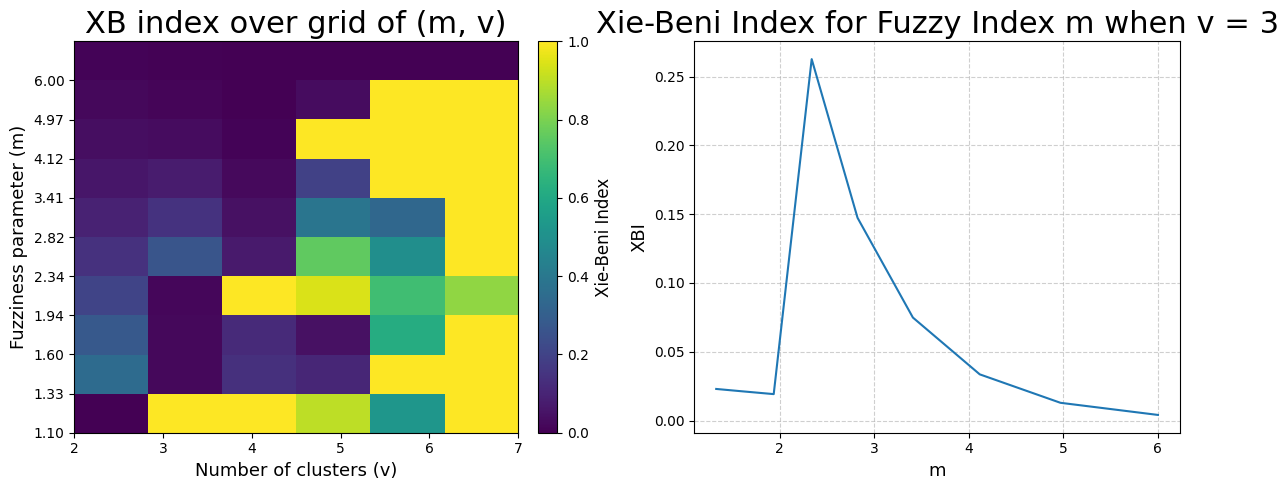

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# -------------------------------------------
# (A) Heatmap of XB index
# -------------------------------------------
im = axes[0].imshow(
    xb_replaced, aspect="auto", cmap="viridis",
    extent=[c_candidates.min(), c_candidates.max(), 1, 11],
    origin="lower", vmin=0, vmax=1
)
axes[0].set_yticks(np.arange(1, 11))
axes[0].set_yticklabels([f"{m:.2f}" for m in m_candidates])
axes[0].set_xlabel("Number of clusters (v)", fontsize=13)
axes[0].set_ylabel("Fuzziness parameter (m)", fontsize=13)
axes[0].set_title("XB index over grid of (m, v)", fontsize=22)

# Add colorbar next to first plot
cbar = fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)
cbar.set_label("Xie-Beni Index", fontsize=12)

# -------------------------------------------
# (B) Line plot for fixed v = 3
# -------------------------------------------
axes[1].plot(np.geomspace(1.1, 6, num=10), xb_matrix[:, 1])
axes[1].set_title("Xie-Beni Index for Fuzzy Index m when v = 3", fontsize=22)
axes[1].set_xlabel("m", fontsize=13)
axes[1].set_ylabel("XBI", fontsize=13)
axes[1].grid(True, linestyle='--', alpha=0.6)

# -------------------------------------------
# Layout adjustment
# -------------------------------------------
plt.tight_layout()
plt.show()
